In [12]:
# Some standard import statements that are nice for Jupyter

import sys
import os
import logging
import ipynb
import decimal

import numpy as np

from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 200

import time

# importing my model functions for analysis
from psi_transmission.model_functions import *

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# some data loads to be performed right away
start_time_dict = get_start_times()
main_data_dict = load_all_data(start_time_dict['bernhard_p_beam'])

# Checking between Edgard and Bernhard's Data

It appears that Bernhard's data and Edgard's data might be completely different. We can plot both.

In [14]:
# load the proton beam data from Edgard
# here we use bernhard's start time for both for comparison
edgard_p_beam_data = load_p_beam_data(start_time_dict['bernhard_p_beam'])

# load the proton beam data from Bernhard 
bernhard_p_beam_data = load_bern_p_beam_data(start_time_dict['bernhard_p_beam'])

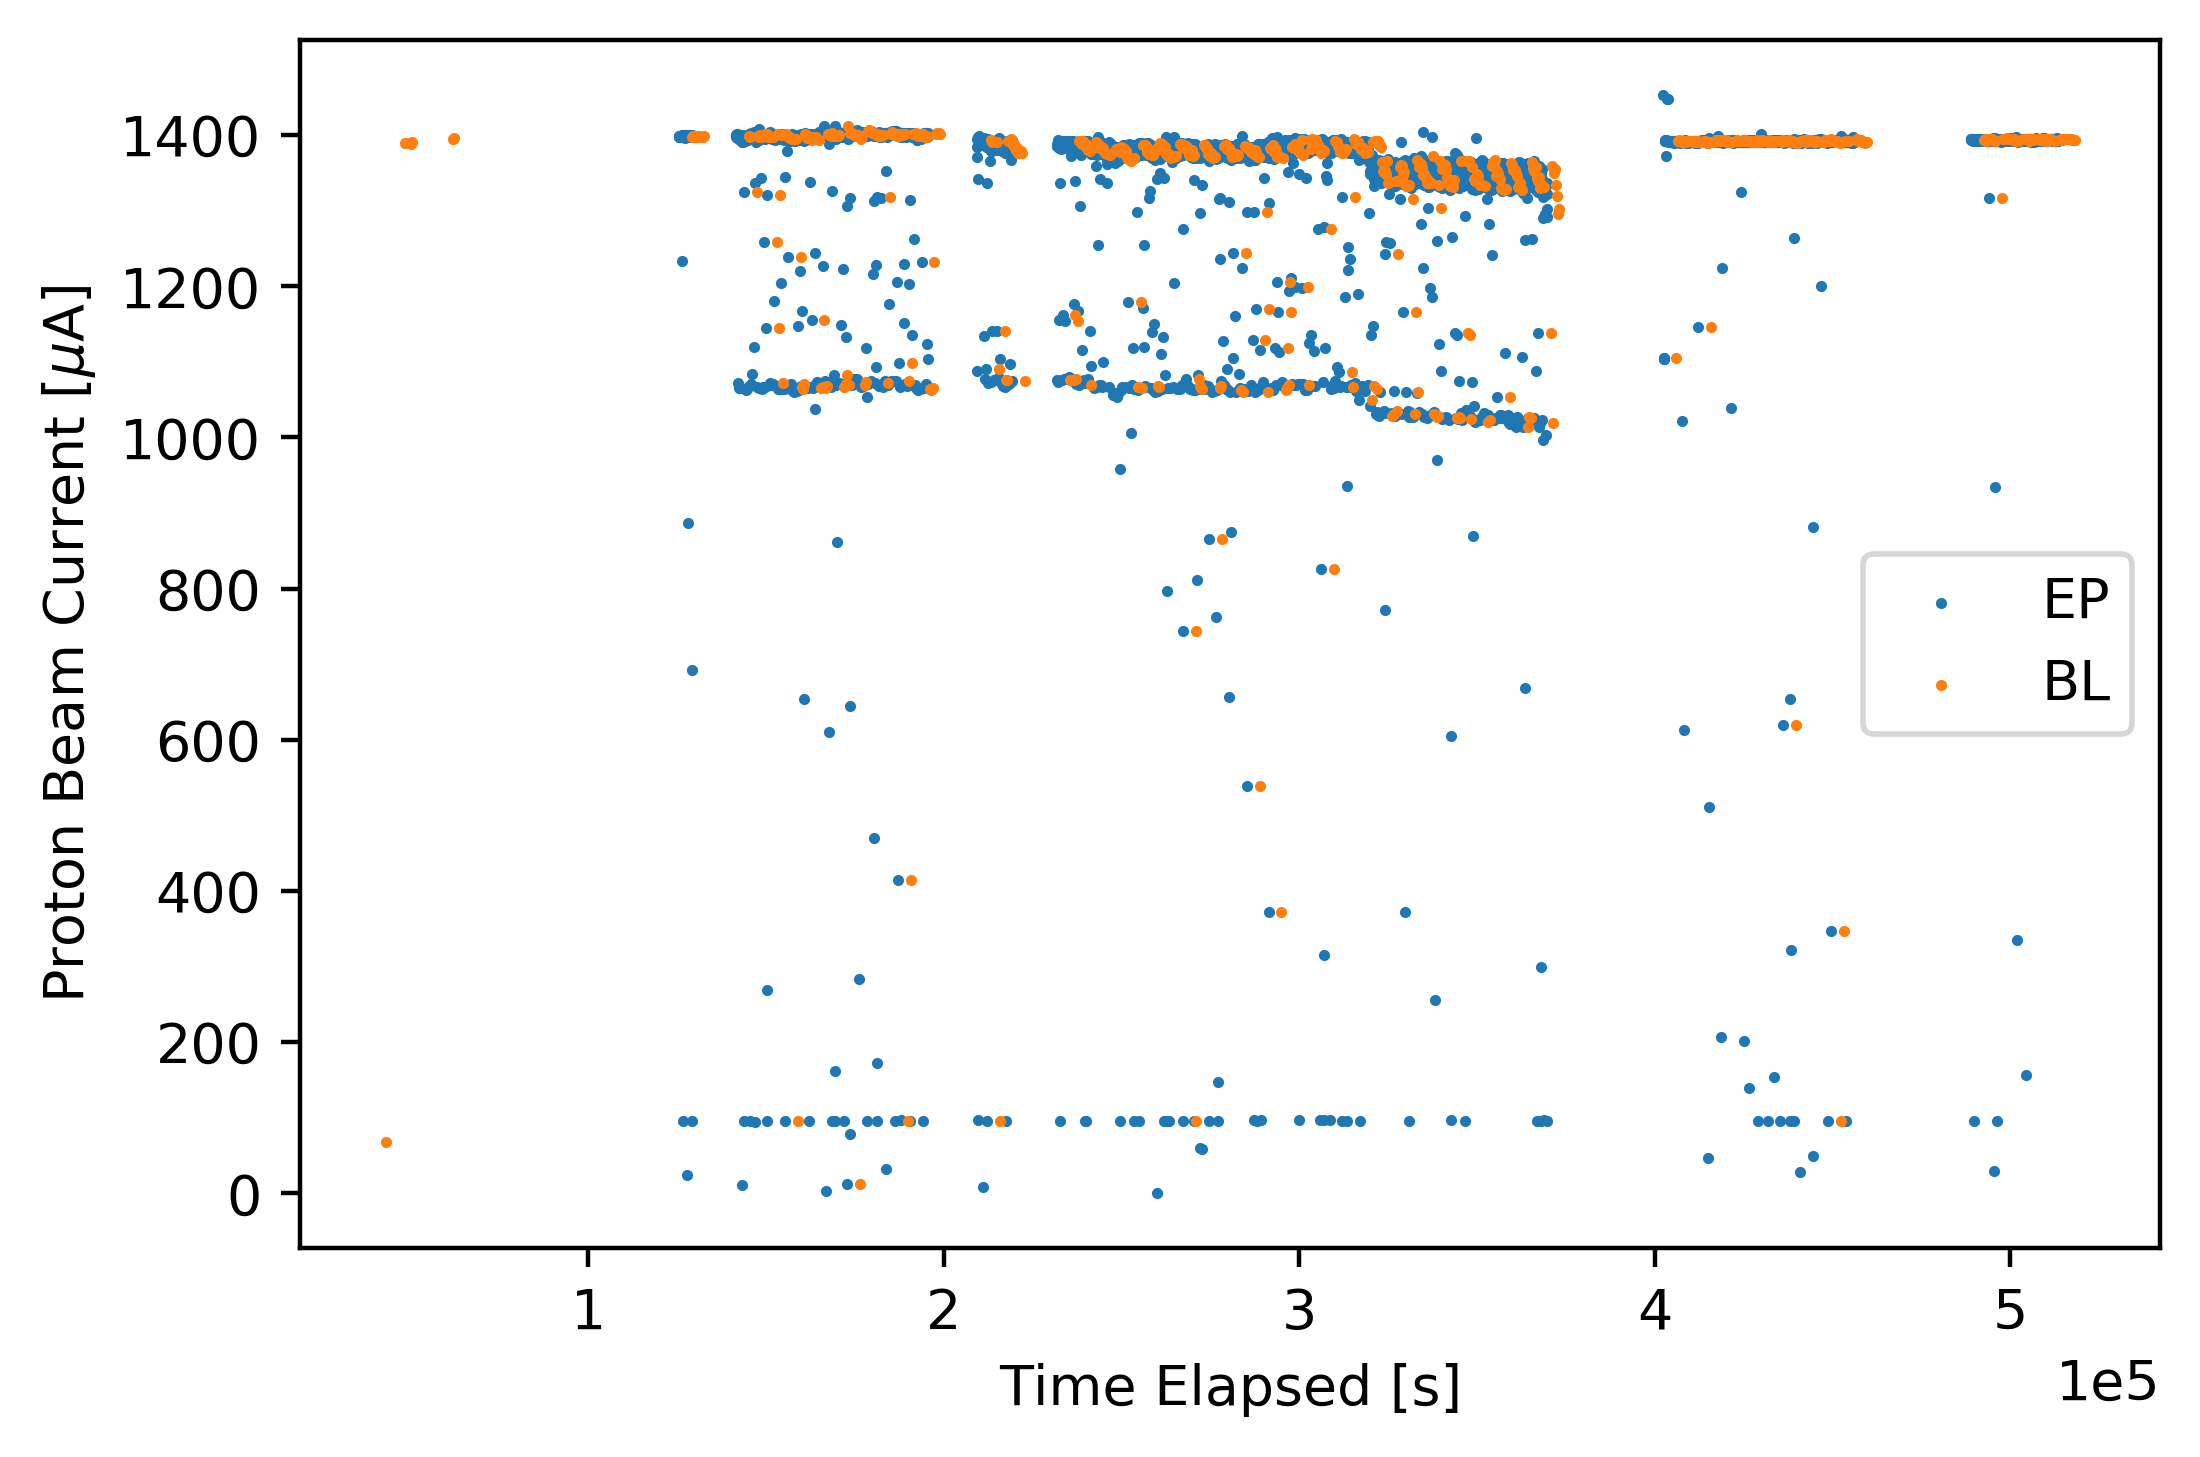

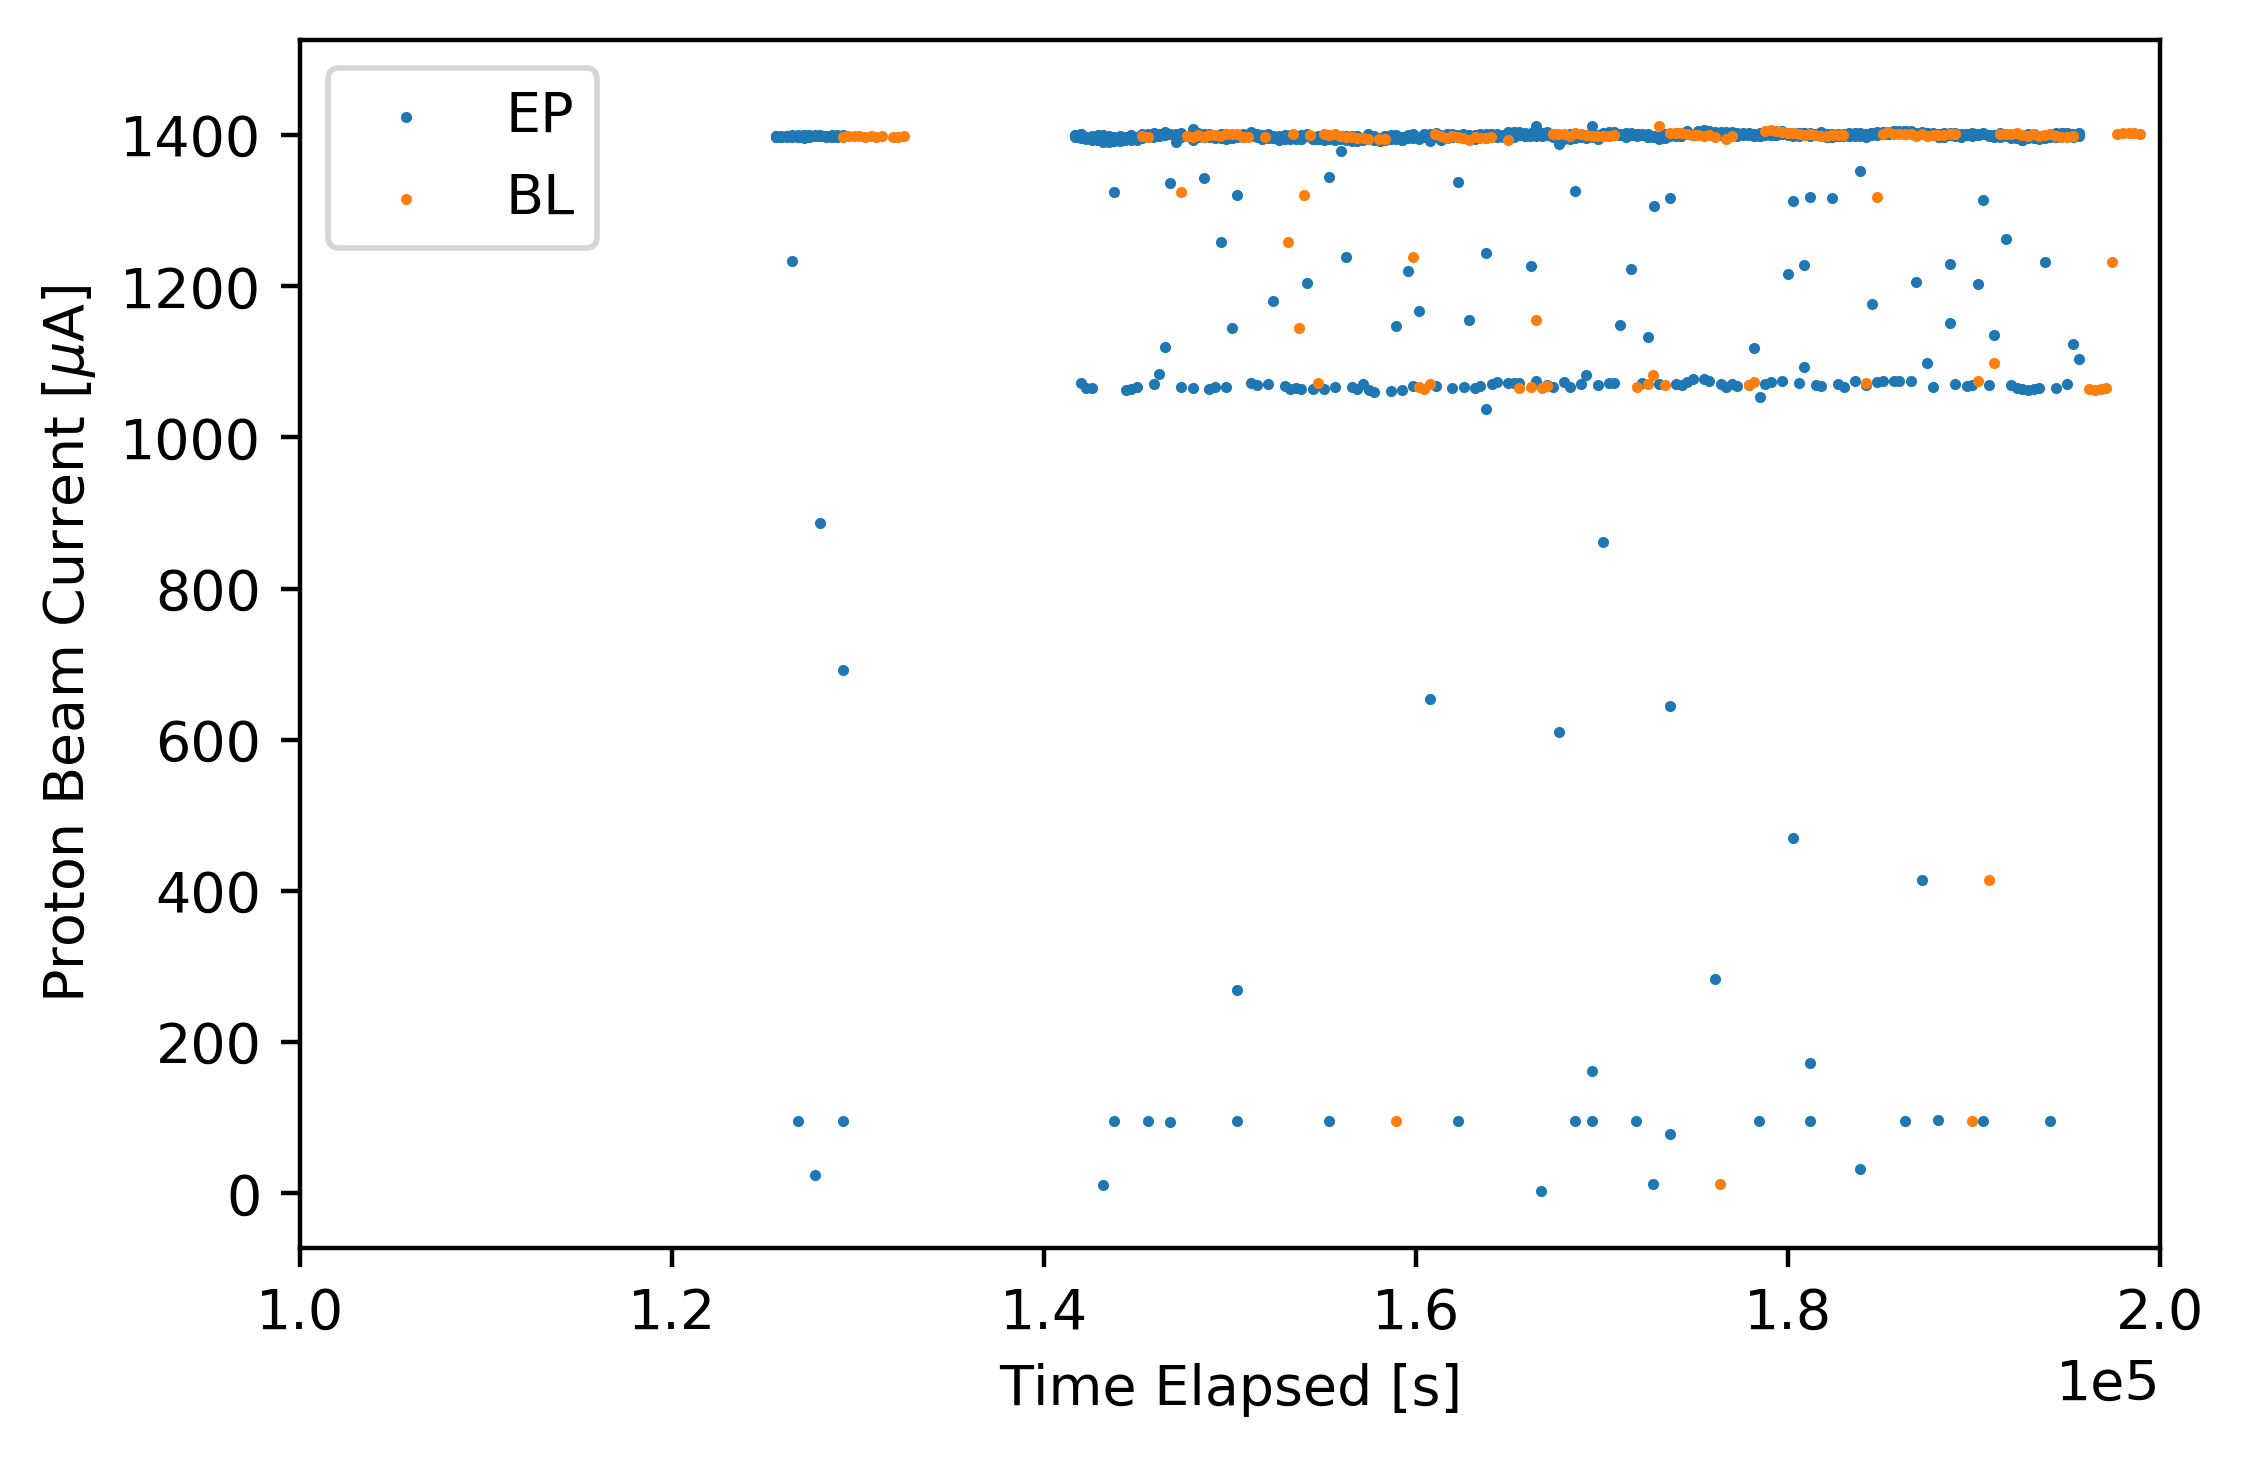

In [15]:
plt.scatter(edgard_p_beam_data[:,0], edgard_p_beam_data[:,1], s=1, label = 'EP');
plt.scatter(bernhard_p_beam_data[:,0], bernhard_p_beam_data[:,2], s=1, label = 'BL');
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('Time Elapsed [s]');
plt.ylabel(r'Proton Beam Current [$\mu$A]');
plt.legend();
plt.show()

plt.clf()
plt.scatter(edgard_p_beam_data[:,0], edgard_p_beam_data[:,1], s=1, label = 'EP');
plt.scatter(bernhard_p_beam_data[:,0], bernhard_p_beam_data[:,2], s=1, label = 'BL');
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('Time Elapsed [s]');
plt.ylabel(r'Proton Beam Current [$\mu$A]');
plt.legend();
plt.xlim([1e5,2e5])
plt.show()

They're not completely different, but there are disagreements. It's not clear what data set Edgard is using. This query will be forwarded to him. 

Assuming there's some issue with Edgard's data, we ought to move forward using Bernhard's since it appears to be a more raw version of the data

# Proton Beam Fluctuations

The plot from Edgard's slides is shown below. I believe he is showing some version of the proton beam timing data, which Bernhard refers to with skepticism in his email:

>2RGQ00CE006   -  this is the proton beam current towards UCN - you can see when pulses appeared<br/>
but you cannot trust the absolute value for various reasons - so do notu se as monitoring detector

![](../misc/p_beam_fluctuate.png)
![](jonahberean/psi_transmission/misc/p_beam_fluctuate.png)

The actual monitoring data from Bernhard is what we will use for the analysis.

>2RGQ00CE004      this is the proton beam current which you can use for monitoring <br/>
this detector measures the proton beam current at the exit of the cyclotron

## Plotting All Proton Beam Data

Below all of the proton beam monitoring data are plotted.

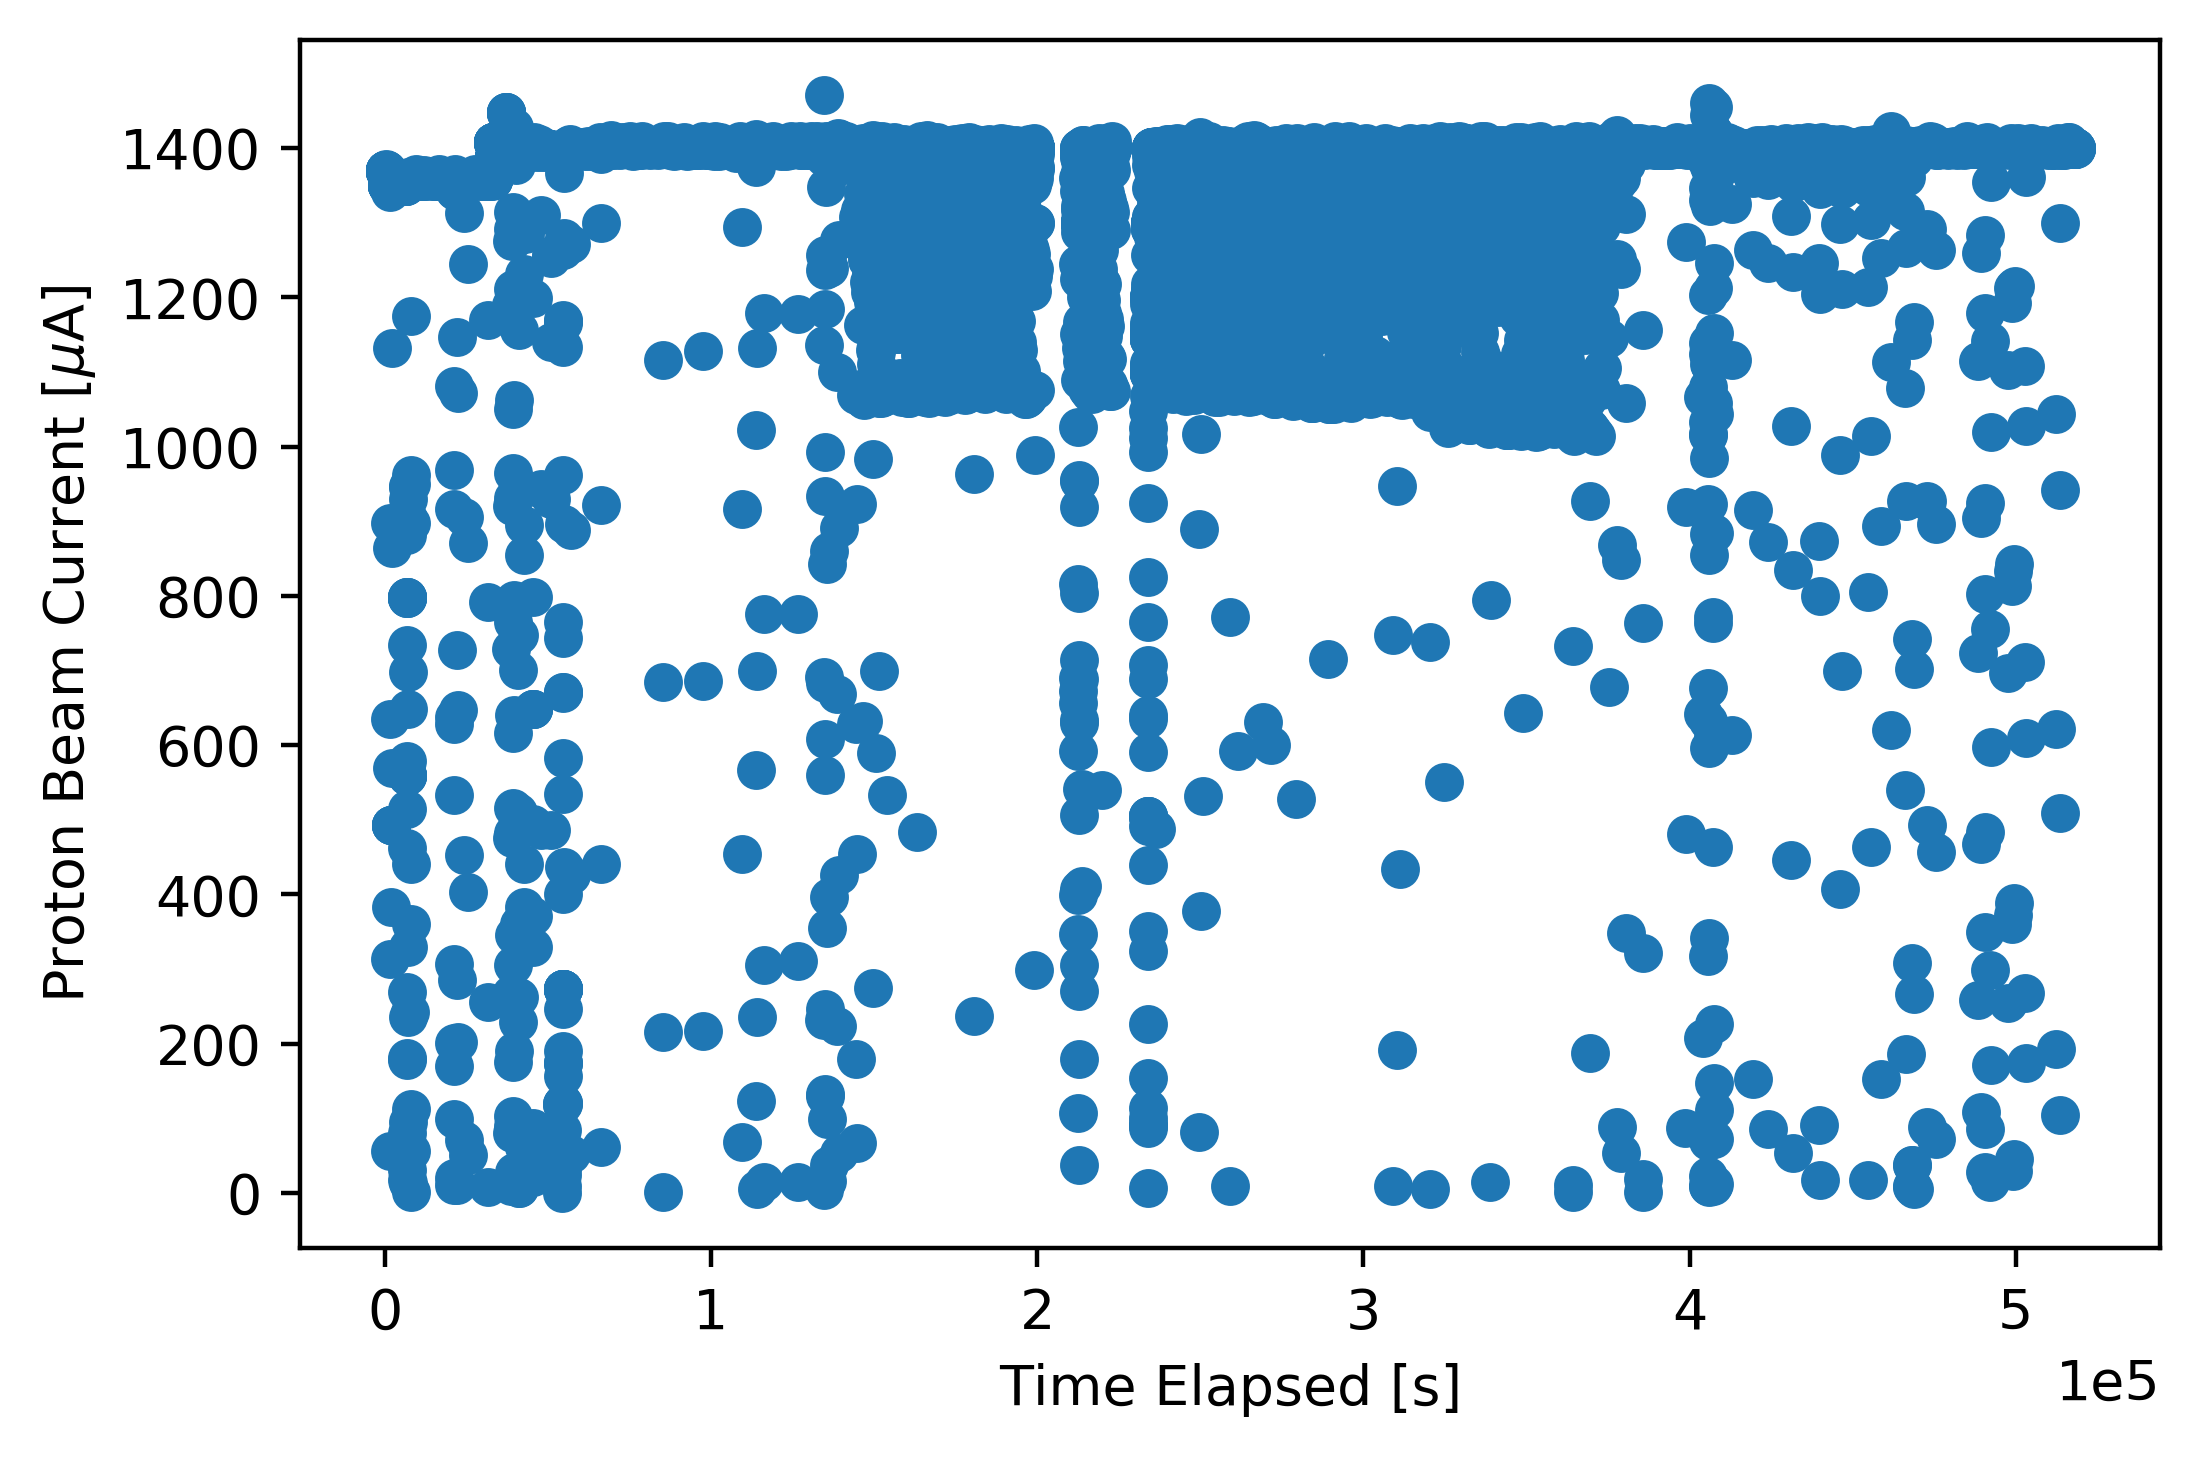

In [16]:
###############################################################################

# we use bernhard's data
arr = bernhard_p_beam_data

# plot all of the monitoring current data
plt.scatter(arr[:,0], arr[:,1])
plt.xlabel('Time Elapsed [s]');
plt.ylabel(r'Proton Beam Current [$\mu$A]');
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

###############################################################################

Nothing to parse just yet, but that's the full data set.

## Cross-Referencing the Proton Beam Current Data with Absolute UCN Detected Counts

The main detector run data files that we got from Edgard largely match what we see in the elog, meaning that his selection of runs based on cyclotron fluctuations was probably predictable during the beam time. Here we will be looking for large fluctuations of the neutron counts from individual runs, and we want to see those fluctuations in the context of fluctuating proton beam currents. 

We're expecting neutron transmission values through the guides of ~0.5-0.9, so for a preliminary analysis we can go ahead and look at the counts without any configuration-dependent re-normalization of the total count rates. However, a re-normalization of all the data according to time elapsed - since the first experimental run - will be performed to account for the decline in absolute UCN counts over time. 

Here are the preliminary results for transmission from Edgard, as justification for my rough approach:

![](../misc/triumf_guide_transmission.png)
![](jonahberean/psi_transmission/misc/triumf_guide_transmission.png)

![](../misc/jp_guide_transmission.png)
![](jonahberean/psi_transmission/misc/jp_guide_transmission.png)

### Plotting every Main Detector Run with the Proton Beam Current Data

Next we can take the main detector data from every run, and plot it alongside the proton beam current data. To start, we'll use only those runs that were accepted by Edgard (even less than this really, as I also made some cuts from what was available after reviewing the elog). I'm ignoring the normalization to any absolute UCN yield changes, for now.

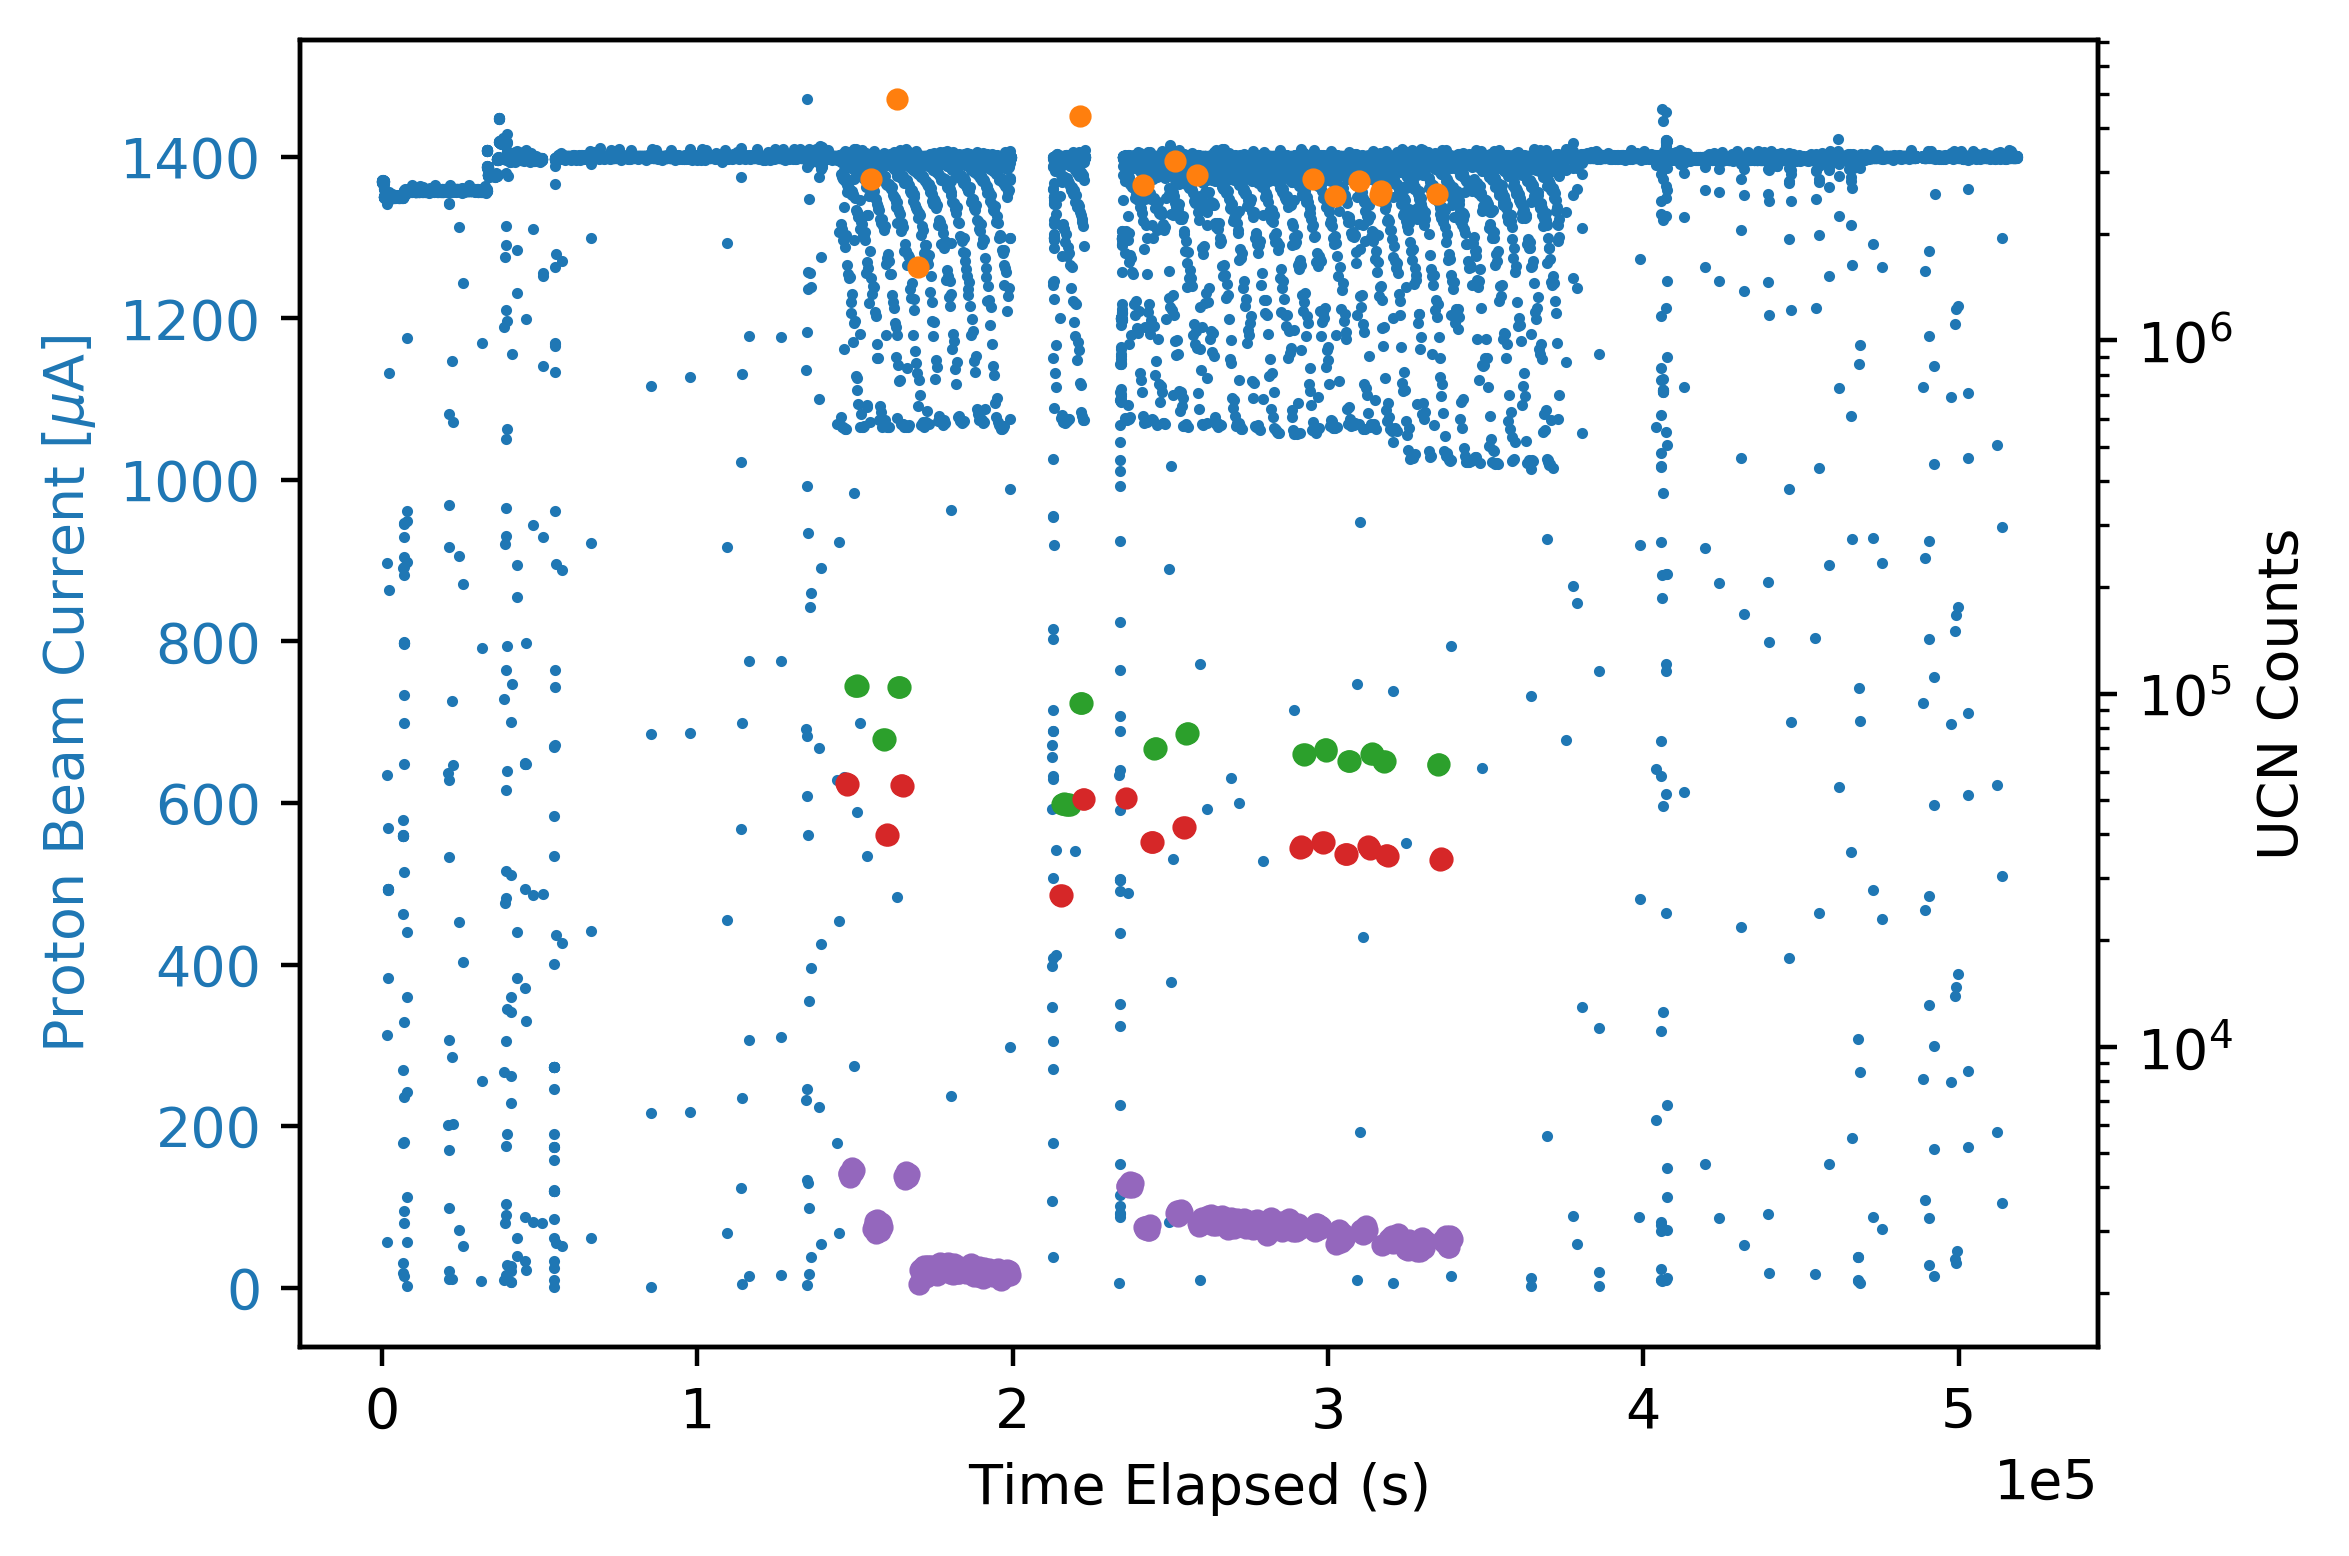

In [17]:
###############################################################################
# instantiate the subplots 
fig, ax1 = plt.subplots()

# for colour consistency in plotting
ax = plt.gca()

# for colour consistency in plotting
color = next(ax._get_lines.prop_cycler)['color']

ax1.set_xlabel('Time Elapsed (s)')

# narrow the x range to where our main detector run data are
# ax1.set_xlim([0.5e5,1e5])

ax1.set_ylabel(r'Proton Beam Current [$\mu$A]', color=color)

# plot all of bernhard's monitoring data
arr = bernhard_p_beam_data
ax1.scatter(arr[:,0], arr[:,1], s=1)

ax1.tick_params(axis='y', labelcolor=color)
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

for run_type in ['s000', 's005', 's020', 's100']:
    
    # for colour consistency in plotting
    color = next(ax._get_lines.prop_cycler)['color']
    
    # plot every run of data, no normalization
    arr = main_data_dict['all', run_type]
    
    ax2.errorbar(arr[:,0], arr[:,2], yerr = arr[:,3], fmt = '.', color = color)

# we already handled the x-label with ax1
ax2.set_ylabel('UCN Counts')  
ax2.set_yscale('log')

# otherwise the right y-label is slightly clipped
fig.tight_layout()  
###############################################################################

To get a more granular look at this data, we will plot only proton beam current data points that are within a 1 minute range of our run start times.

!!! Does the weirdness in the middle coincide with the weirdness we saw with the monitor count data?

In [18]:
window_dict = {}

In [19]:
###############################################################################

data_arr = main_data_dict['all', 'all']

arr = bernhard_p_beam_data

new_arr = np.empty((0,3), float)
for i in range(0, np.shape(data_arr)[0]):
    
    for j in range(0, np.shape(arr)[0]):
        
        abs_diff = abs(data_arr[i,0] - arr[j,0])
        diff = data_arr[i,0] - arr[j,0]
        
        if (abs_diff < 11 and diff > 0 and arr[j,1] < 1380):

            new_arr = np.append(new_arr, [arr[j,:]], axis = 0)

###############################################################################

In [20]:
window_dict['11s_before', 'below_1380'] = new_arr

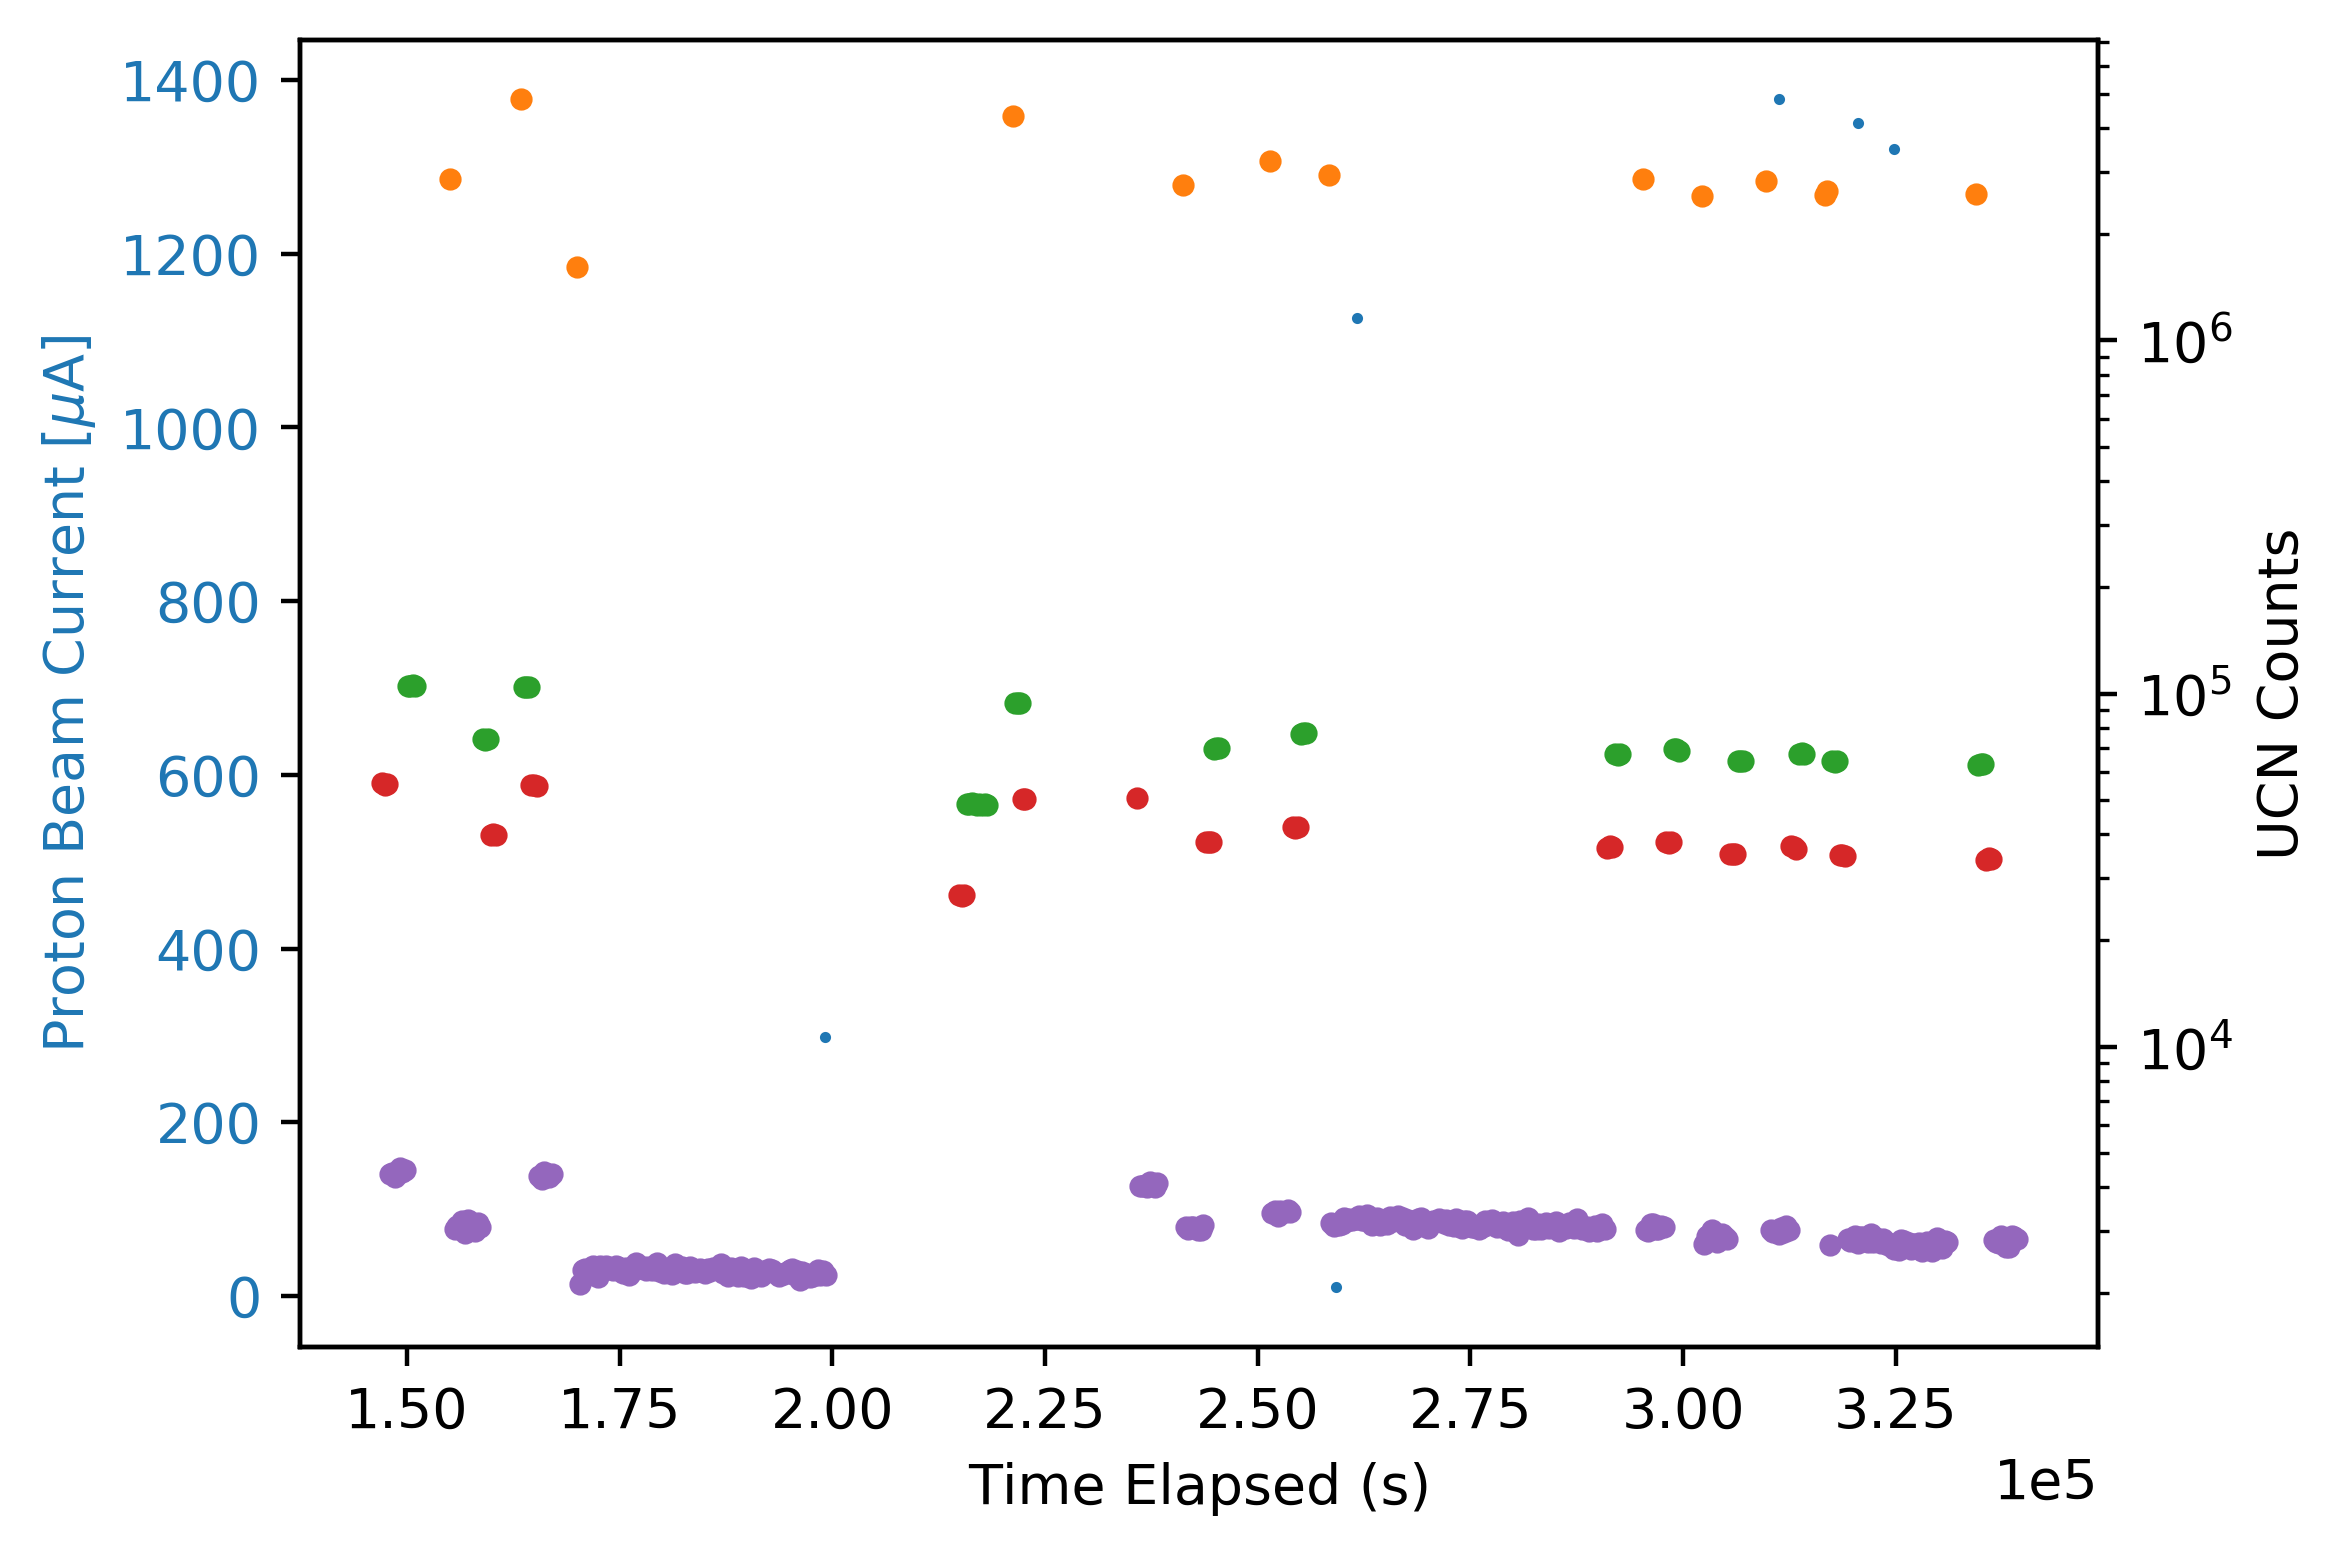

In [21]:
###############################################################################
# instantiate the subplots 
fig, ax1 = plt.subplots()

# for colour consistency in plotting
ax = plt.gca()

# for colour consistency in plotting
color = next(ax._get_lines.prop_cycler)['color']

ax1.set_xlabel('Time Elapsed (s)')

# narrow the x range to where our main detector run data are
# ax1.set_xlim([1.5e5,1.6e5])
# ax1.set_ylim([1350, 1450])

ax1.set_ylabel(r'Proton Beam Current [$\mu$A]', color=color)

# plot all of bernhard's monitoring data
arr = window_dict['11s_before', 'below_1380']
ax1.scatter(arr[:,0], arr[:,1], s=1)

ax1.tick_params(axis='y', labelcolor=color)
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

for run_type in ['s000', 's005', 's020', 's100']:
    
    # for colour consistency in plotting
    color = next(ax._get_lines.prop_cycler)['color']
    
    # plot every run of data, no normalization
    arr = main_data_dict['all', run_type]
    
    ax2.errorbar(arr[:,0], arr[:,2], yerr = arr[:,3], fmt = '.', color = color)

# we already handled the x-label with ax1
ax2.set_ylabel('UCN Counts')  
ax2.set_yscale('log')

# otherwise the right y-label is slightly clipped
fig.tight_layout()  
###############################################################################

Here I'm plotting any proton beam current measurement that occurs within a 10 second time window of the start of a run.

The methodology here is on the right track, but I need to interrupt this progress in order to look at a new set of data provided by Edgard and Bernhard. 

## New 0.5 Hz Data from Edgard via Bernhard

This data set for proton beam current is the original set sent to Edgard in 2017 by Bernhard. 

In [29]:
p_beam_data_3 = load_p_beam_data_3(start_time_dict['bernhard_p_beam'])

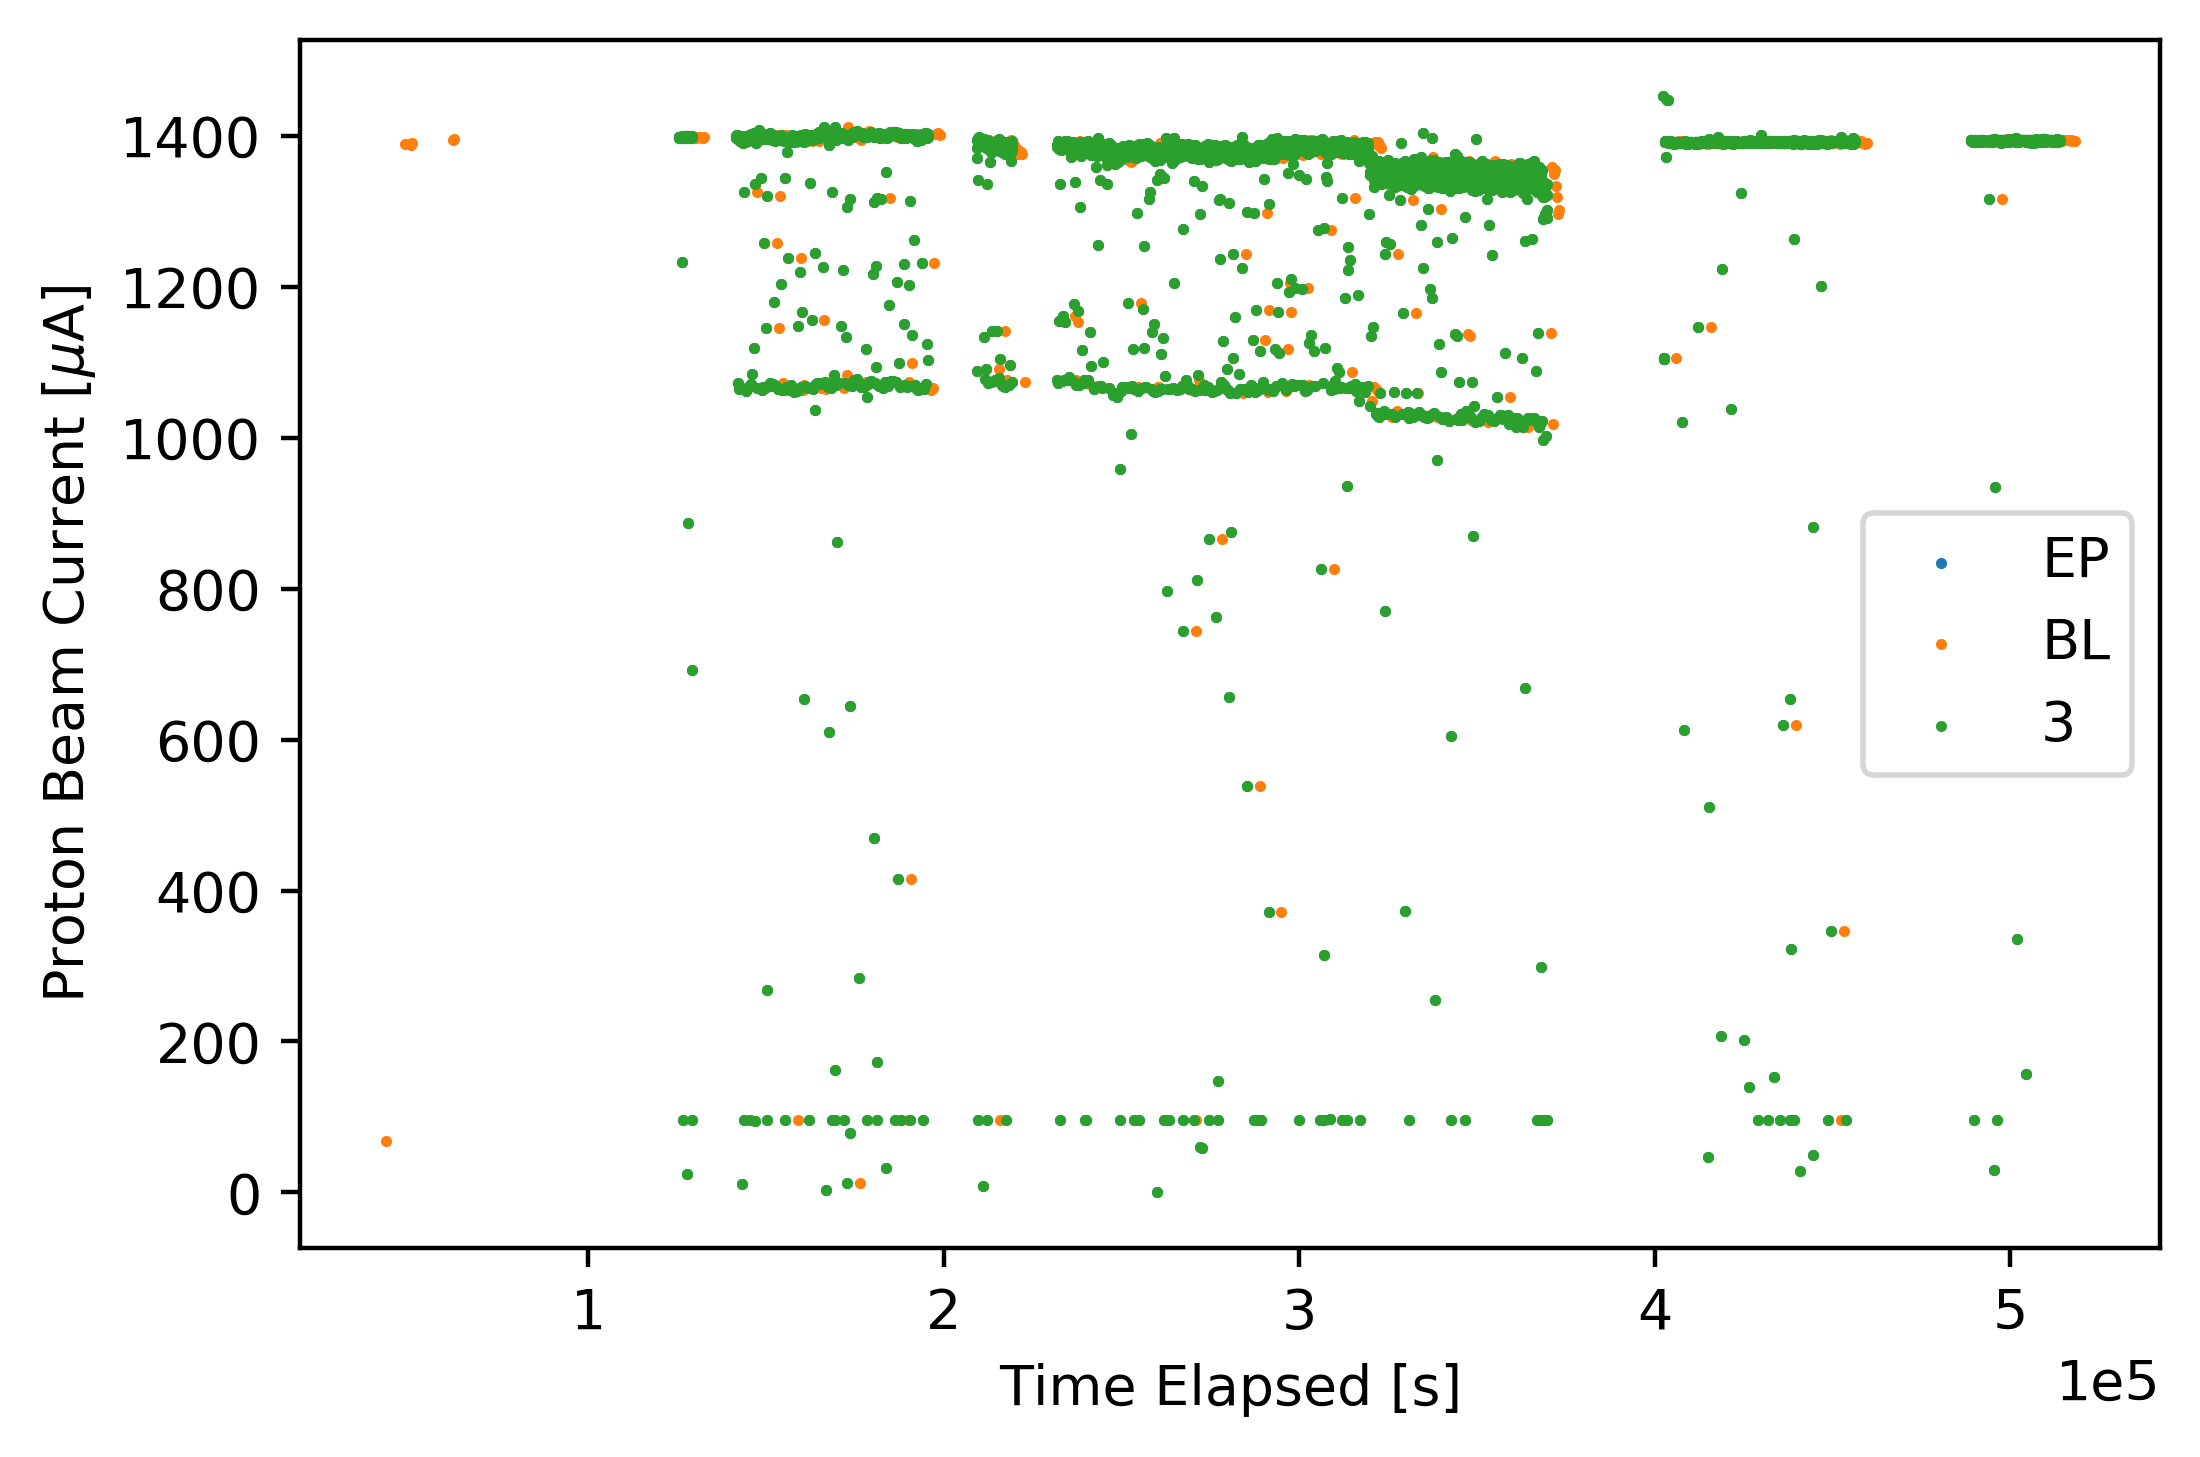

In [30]:
plt.scatter(edgard_p_beam_data[:,0], edgard_p_beam_data[:,1], s=1, label = 'EP');
plt.scatter(bernhard_p_beam_data[:,0], bernhard_p_beam_data[:,2], s=1, label = 'BL');
plt.scatter(p_beam_data_3[:,0], p_beam_data_3[:,1], s=1, label = '3');
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('Time Elapsed [s]');
plt.ylabel(r'Proton Beam Current [$\mu$A]');
plt.legend();
plt.show()

plt.clf()
plt.scatter(edgard_p_beam_data[:,0], edgard_p_beam_data[:,1], s=1, label = 'EP');
plt.scatter(bernhard_p_beam_data[:,0], bernhard_p_beam_data[:,2], s=1, label = 'BL');
plt.scatter(p_beam_data_3[:,0], p_beam_data_3[:,1], s=1, label = '3');
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('Time Elapsed [s]');
plt.ylabel(r'Proton Beam Current [$\mu$A]');
plt.legend();
plt.show()